# Classification of US Airline Sentiments with dense layer

## 1. Introduction

 In this scenario, the objective is to perform a multi-class classification task, specifically categorizing sentiments related to Twitter posts about US airlines into three distinct classes. This implies that the model aims to classify tweets into positive, negative, or neutral sentiments. This is based off the Kaggle Twitter US Airline Sentiment: 
 - https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment.
 
There were articles such as Airbnb's effort at discovering and classifying message intent from Airbnb to classify guests and allow them to response to them more quickly. This is similar to the project in terms of analysing user's intent based on sentiments (Du, 2019).

The dataset utilized for this task is characterized by imbalances, meaning that the distribution of tweets across the three sentiment classes is not uniform. One or more sentiment classes may have a significantly larger or smaller number of instances compared to the others.

 The data is unstructured and comprises text data in the form of tweets. This type of data poses challenges for traditional machine learning models (Priya, 2023), as it requires natural language processing (NLP) techniques to extract meaningful information and patterns from the text.

 To transform the raw text data into a format suitable for machine learning models, Term Frequency-Inverse Document Frequency (TF-IDF) vectors are employed. This technique quantifies the importance of each word in a tweet relative to the entire dataset, providing a numerical representation of the textual information.

The model output is designed to predict the probabilities of the input tweets belonging to each sentiment class. Instead of providing a definitive classification, the model offers a probability distribution across the three classes, allowing for a more nuanced interpretation of the sentiment expressed in the tweets.

Given the imbalanced nature of the data, where some sentiment classes may have more instances than others, addressing this issue becomes crucial. To mitigate the impact of imbalances during the training phase, class weights are employed. This involves assigning higher weights to the under-represented classes, allowing the model to place more emphasis on learning patterns from these classes and preventing biased predictions towards the majority class.



## 2. Measure of success

In the context of the Kaggle Twitter US Airline Sentiment dataset, where the task involves multi-class sentiment analysis, the evaluation protocol encompasses defining the problem, assembling the dataset, selecting metrics like Balanced Accuracy Score, Precision, Recall, AUC, and F1 Score, and employing both a hold-out validation set and K-fold cross-validation to comprehensively assess the success of the machine learning models. 

Given the nature of the sentiment analysis, metrics suitable for multi-class classifications such as Balanced Accuracy Score is good for imbalanced data. Preicision and recall can measure accuracy of positive classifications while detecting positive sentiments. AUC  can distinguish between classes, and F1 scores consider positive and false negatives to balance precision and recall.

K-Fold Cross-Validation can evaluate model performance especially when the dataset size is limited.The dataset is partitioned into k subsets (folds), and the model is trained and evaluated k times, each time using a different fold as the validation set.







In [67]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout, TextVectorization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import F1Score, AUC

import itertools
import matplotlib.pyplot as plt

SEED =204


## 4. Preparing data

Since the data is already compiled by its sentiments, can drop all the other features.

In [112]:
tweets = pd.read_csv("Tweets.csv")
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [69]:
tweets = tweets[['text', 'airline_sentiment']]
tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [70]:
TEST_SIZE=0.2
X_train, X_test, y_train, y_test = train_test_split(tweets['text'], tweets['airline_sentiment'], test_size=TEST_SIZE, stratify=tweets['airline_sentiment'], shuffle=True, random_state=SEED)

In [71]:
ngrams = 2 
'very', 'good', 'very good', 'not good'

('very', 'good', 'very good', 'not good')

In [72]:
max_features = 500
ngrams = 2
tfidf = TfidfVectorizer(ngram_range=(1, ngrams), max_features= max_features)
tfidf.fit(X_train)

x_train, x_test = tfidf.transform(X_train).toarray(), tfidf.transform(X_test).toarray()

In [73]:
label_encoder = LabelEncoder()
label_encoder.fit(tweets['airline_sentiment'])

Y_train = to_categorical(label_encoder.transform(y_train))
Y_test = to_categorical(label_encoder.transform(y_test))

In [74]:
validation_size = x_test.shape[0]

x_train, x_val, Y_train, Y_val = train_test_split(x_train, Y_train,
                                                 test_size= validation_size , stratify= Y_train,
                                                 shuffle=True, random_state=SEED)

## 5. Developing a model that do better than baseline:

A Single Layer Perceptron (SLP) model likely to outperform a naive baseline. The non-linear relationships between words and sentiment labels uses SLP nonlinear activation to learn complext patterns to better model the nuances of sentiment expression. Further, the imbalanced dataset uses SLP to adjust weights during training so that it does not favour majority classes and provide a more balanced sentiment analysis.


In [75]:
counts = tweets.groupby(['airline_sentiment']).count()
counts.reset_index(inplace=True)
counts

,airline_sentiment,text
0,negative,9178
1,neutral,3099
2,positive,2363


In [76]:
naive_baseline = counts[counts['airline_sentiment']=='negative']['text'].values[0] / counts['text'].sum()

naive_baseline

0.6269125683060109

In [77]:
labels = np.argmax(Y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(weights))

class_weights

{0: 0.531686943889595, 1: 1.5750403442711136, 2: 2.0648801128349787}

In [78]:
input_dimens = x_train.shape[1]
output = Y_train.shape[1]
optimizer = 'rmsprop'
loss_funct = 'categorical_crossentropy'
METRICS = ['categorical_accuracy',F1Score(name='f1_score', average='macro'), AUC(name='auc', multi_label=True)]
MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [79]:
baseline = Sequential([Dense(output, activation='softmax', input_shape=(input_dimens,))],name="Baseline")

baseline.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 1503      
                                                                 
Total params: 1503 (5.87 KB)
Trainable params: 1503 (5.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
learning_rate = 0.01
batch_size = 512

EPOCHS = 100

baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=loss_funct, metrics=METRICS)


In [81]:
baseline_history = baseline.fit(x_train, Y_train,
                                class_weight=class_weights,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(x_val, Y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

baseline_scores = baseline.evaluate(x_val, Y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(baseline_scores[1]))
print('AUC (Validation): {:.2f}'.format(baseline_scores[2]))

Accuracy (Validation): 0.74 (Naive Baseline=0.63)
F1 Score (Validation): 0.69
AUC (Validation): 0.89


In [82]:
preds = baseline.predict(x_val, verbose=0).argmax(axis=1)

print('Balanced Accuracy (Validation): {:.2f} (baseline = {:.2f})'.format(balanced_accuracy_score(Y_val.argmax(axis=1), preds), naive_baseline))


Balanced Accuracy (Validation): 0.71 (baseline = 0.63)


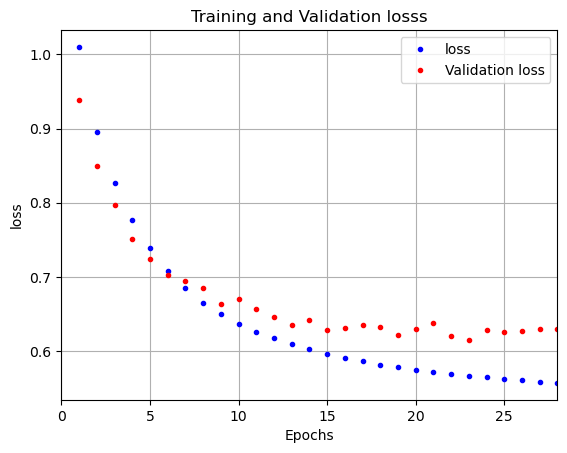

In [83]:
def plot_training_history(history, monitor='loss') :
    # Extract training and validation loss values from the history object
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    # Define the x-axis as the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training loss in blue and validation loss in red
    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)

    # Set x-axis limits
    plt.xlim([0, len(loss)])

    # Set plot title and labels
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)

    # Add legend, grid, and display the plot
    plt.legend()
    plt.grid()
    _ = plt.show()
    
plot_training_history(baseline_history, monitor='loss')

## 6. Scaling up: develop model that overfits

To introduce complexity and increase variance, escalate to a model designed for over-fitting the data. Striking a balance, we include at least one hidden layer with a substantial number of hidden neurons. For the Twitter example, we adopt a configuration of 1 hidden layer and 64 hidden neurons. In this instance, I refer to it as an "overfitted" model.

In [84]:
overfit = Sequential([Dense(64, activation="relu", input_shape=(input_dimens,), name="hidden"),
        Dense(output, activation="softmax", name="output")],name="Overfit"
)

overfit.summary()

Model: "Overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 64)                32064     
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 32259 (126.01 KB)
Trainable params: 32259 (126.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
learning_rate = 0.0025

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=loss_funct, metrics=METRICS)

In [86]:
EPOCHS = 100
batch_size=512

overfit_history = overfit.fit(x_train, Y_train,
                              class_weight=class_weights,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(x_val, Y_val),
                              callbacks=[],
                              verbose=0)

In [87]:
overfit_scores = overfit.evaluate(x_val, Y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(overfit_scores[1]))
print('AUC (Validation): {:.2f}'.format(overfit_scores[2]))

Accuracy (Validation): 0.75 (Naive Baseline = 0.63)
F1 Score (Validation): 0.68
AUC (Validation): 0.87


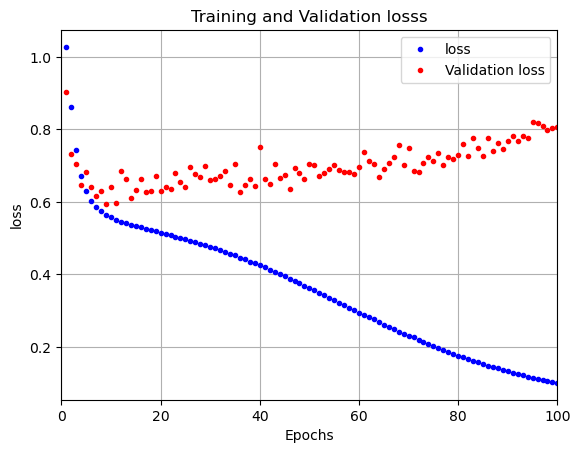

In [88]:
plot_training_history(overfit_history, monitor='loss')


## 7. Regularizing model and tuning hyperparameters:

A comprehensive evaluation of various models on a single dataset is a critical review criterion. This necessitates exploring multiple models, not just focusing on our overfitted one. Therefore, I introduce two additional models:

- A "wider" model, comprising 1 hidden layer, 1 dropout layer, and 128 neurons.
- A "deeper" model, featuring 2 hidden layers, 2 dropout layers, and 64 neurons for each hidden layer.
For the overfitted model, we insert 1 dropout layer and rename it as "deep."

The wider and deeper models possess the potential for overfitting due to their increased complexity compared to the deep (or overfitted) model.

Subsequently, a grid search and k-fold validation are executed to identify optimal hyperparameters. 

In [89]:
# over-sized model 
deep = Sequential([ Dense(64,  kernel_regularizer=l2(0.0), activation='relu', input_shape=(input_dimens,), name='hidden'),Dropout(rate=0.5),
        Dense(output,  activation='softmax', name='output')], name="Deep"
)

deep.summary()

Model: "Deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 64)                32064     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 32259 (126.01 KB)
Trainable params: 32259 (126.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
wider = Sequential([Dense(128,  kernel_regularizer=l2(0.0), activation='relu', input_shape=(input_dimens,), name='hidden'),Dropout(0.5),
        Dense(output,  activation='softmax', name='ouput')],name = 'Wider'
)

wider.summary()

Model: "Wider"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 128)               64128     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 ouput (Dense)               (None, 3)                 387       
                                                                 
Total params: 64515 (252.01 KB)
Trainable params: 64515 (252.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
deeper = Sequential([Dense(64,  kernel_regularizer=l2(0.0), activation='relu', input_shape=(input_dimens,), name='hidden.0'),
        Dropout(rate=0.5),
        Dense(64,  kernel_regularizer=l2(0.0), activation='relu', name='hidden.1'),
        Dropout(rate=0.5),
        Dense(output,  activation='softmax', name='output')],name = 'Deeper'
)

deeper.summary()

Model: "Deeper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden.0 (Dense)            (None, 64)                32064     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 hidden.1 (Dense)            (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 36419 (142.26 KB)
Trainable params: 36419 (142.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
narrower = Sequential([ Dense(32,  kernel_regularizer=l2(0.0), activation='relu', input_shape=(input_dimens,), name='hidden'),
        Dropout(rate=0.5),
        Dense(output,  activation='softmax', name='output')],name = 'Narrower'
)

narrower.summary()

Model: "Narrower"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 32)                16032     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 output (Dense)              (None, 3)                 99        
                                                                 
Total params: 16131 (63.01 KB)
Trainable params: 16131 (63.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
parameters = {
    'dropout': [0.0, 0.25], #25% units drop
    'alpha': [0.0, 0.001], #L2 regularization strength
    'learning_rate': [0.005],
    'batch_size': [512]
}


EPOCHS = 500
KFOLDS = 5

In [94]:
def cross_validation(X, y, cv, model, class_weight, param_grid, loss, metrics, epochs, callbacks, seed=0) :
    kf = KFold(n_splits=cv)
    keys, values = zip(*param_grid.items())

    cvs = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        scores = []
        for i, (train_index, test_index) in enumerate(kf.split(X)) :
            nn = clone_model(model)

            for layer in nn.layers :
                if type(layer) == keras.src.layers.regularization.dropout.Dropout :
                    layer.rate = params['dropout']

                if type(layer) == keras.src.layers.core.dense.Dense :
                     if (layer.activation != 'softmax') or (layer._name != 'output') :
                        layer.kernel_regularizer = l2(params['alpha'])

            nn.compile(optimizer=RMSprop(learning_rate=params['learning_rate']),
                       loss=loss, metrics=metrics)


            nn.fit(X[train_index,:], y[train_index,:],
                   class_weight=class_weight,
                   batch_size=params['batch_size'], epochs=epochs,
                   validation_data=(X[test_index,:], y[test_index,:]),
                   callbacks=callbacks,
                   verbose=0)

            scores.append(nn.evaluate(x_val, Y_val, verbose=0)[1:])

            del nn

        cvs[str(params)] = np.array(scores).mean(axis=0)

    return cvs

In [95]:
cvs_deep = cross_validation(x_train, Y_train, cv=5, model=deep,
                            class_weight=class_weights,
                            param_grid=parameters, loss=loss_funct, metrics=METRICS,
                            epochs=EPOCHS,
                            callbacks=[EARLY_STOP], seed=SEED)

In [96]:
def dict_to_dataframe(cvs, metrics) :
    entries = []
    for key, value in cvs.items() :
        entry = eval(key)

        for metric, score in zip(metrics, value) :
            entry[metric] = score

        entries.append(entry)

    return pd.DataFrame(entries)

In [97]:
cvs_deep = dict_to_dataframe(cvs=cvs_deep, metrics=['accuracy', 'f1_score', 'auc'])

cvs_deep.sort_values(by=['auc'], ascending=False).head(10)

,dropout,alpha,learning_rate,batch_size,accuracy,f1_score,auc
3,0.25,0.001,0.005,512,0.750273,0.695514,0.883257
0,0.00,0.000,0.005,512,0.746926,0.690209,0.882805
2,0.25,0.000,0.005,512,0.752391,0.696104,0.882561
1,0.00,0.001,0.005,512,0.746516,0.692344,0.882211


In [98]:
# best param by AUC (0.883169) deep
# dropout 0.25
# alpha 0.000
# learning rate 0.005
# batch size 512

In [99]:
cvs_deeper = cross_validation(x_train, Y_train, cv=5, model=deeper,
                            class_weight=class_weights,
                            param_grid=parameters, loss=loss_funct, metrics=METRICS,
                            epochs=EPOCHS,
                            callbacks=[EARLY_STOP], seed=SEED)

In [100]:
cvs_deeper = dict_to_dataframe(cvs=cvs_deeper, metrics=['accuracy', 'f1_score', 'auc'])

cvs_deeper.sort_values(by=['auc'], ascending=False).head(10)

,dropout,alpha,learning_rate,batch_size,accuracy,f1_score,auc
3,0.25,0.001,0.005,512,0.764413,0.699769,0.883575
0,0.00,0.000,0.005,512,0.760656,0.696027,0.882630
2,0.25,0.000,0.005,512,0.755464,0.692283,0.882432
1,0.00,0.001,0.005,512,0.758333,0.695794,0.882034


In [101]:
# best param by AUC (0.883569) deeper
# dropout 0.25
# alpha 0.001
# learning rate 0.005
# batch size 512

In [102]:
cvs_wider = cross_validation(x_train, Y_train, cv=5, model=wider,
                             class_weight=class_weights,
                             param_grid=parameters, loss=loss_funct, metrics=METRICS,
                             epochs=EPOCHS,
                             callbacks=[EARLY_STOP], seed=SEED)

In [103]:
cvs_wider = dict_to_dataframe(cvs=cvs_wider, metrics=['accuracy', 'f1_score', 'auc'])

cvs_wider.sort_values(by=['auc'], ascending=False).head(10)

,dropout,alpha,learning_rate,batch_size,accuracy,f1_score,auc
3,0.25,0.001,0.005,512,0.756216,0.698310,0.883942
2,0.25,0.000,0.005,512,0.753142,0.697339,0.883479
1,0.00,0.001,0.005,512,0.753142,0.691843,0.882967
0,0.00,0.000,0.005,512,0.748497,0.691606,0.881715


In [104]:
# best param by AUC (0.883359) wider
# dropout 0.25
# alpha 0.000
# learning rate 0.005
# batch size 512

In [105]:
cvs_narrower = cross_validation(x_train, Y_train, cv=5, model=narrower,
                                class_weight=class_weights,
                                param_grid=parameters, loss=loss_funct, metrics=METRICS,
                                epochs=EPOCHS,
                                callbacks=[EARLY_STOP], seed=SEED)

In [106]:
cvs_narrower = dict_to_dataframe(cvs=cvs_narrower, metrics=['accuracy', 'f1_score', 'auc'])

cvs_narrower.sort_values(by=['auc'], ascending=False).head(10)

,dropout,alpha,learning_rate,batch_size,accuracy,f1_score,auc
2,0.25,0.000,0.005,512,0.747746,0.693197,0.883151
0,0.00,0.000,0.005,512,0.748497,0.693023,0.882784
1,0.00,0.001,0.005,512,0.744467,0.692006,0.882345
3,0.25,0.001,0.005,512,0.748497,0.695478,0.882302


In [107]:
# best param by AUC (0.884238) narrower
# dropout 0.25
# alpha 0.000
# learning rate 0.005
# batch size 512

## 8. Testing

In [108]:
#deep
best_params = {
    'dropout': 0.25,
    'alpha': 0.00,
    'learning_rate': 0.005,
    'batch_size': 512
}

best_model = clone_model(deep)
best_model.layers[0].kernel_regularizer = l2(best_params['alpha'])
best_model.layers[1].rate = best_params['dropout'] # dropout layer

best_model.compile(optimizer=RMSprop(learning_rate=best_params['learning_rate']),
                   loss=loss_funct, metrics=METRICS)

history = best_model.fit(x_train, Y_train,
                         class_weight=class_weights,
                         batch_size=best_params['batch_size'], epochs=EPOCHS,
                         validation_data=(x_val, Y_val),
                         callbacks=[EARLY_STOP],
                         verbose=0)

In [109]:
validation_scores = best_model.evaluate(x_val, Y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(validation_scores[1]))
print('AUC (Validation): {:.2f}'.format(validation_scores[2]))

Accuracy (Validation): 0.76 (Naive Baseline = 0.63)
F1 Score (Validation): 0.70
AUC (Validation): 0.89


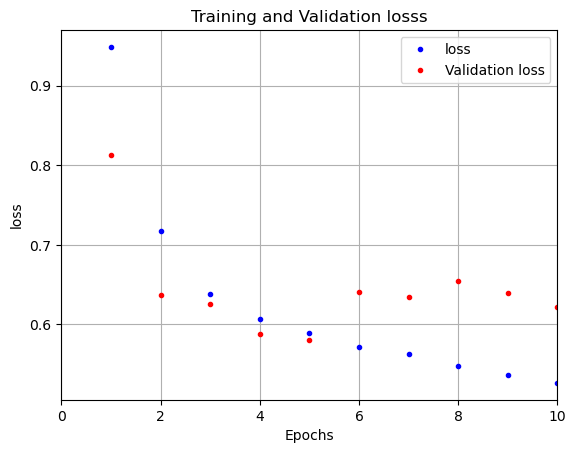

In [110]:
plot_training_history(history, monitor='loss')

In [111]:
test_scores = best_model.evaluate(x_test, Y_test, verbose=0)[1:]

print('Accuracy (Test): {:.2f} (Naive Baseline = {:.2f})'.format(test_scores[0], naive_baseline))
print('F1 Score (Test): {:.2f}'.format(test_scores[1]))
print('AUC (Test): {:.2f}'.format(test_scores[2]))

Accuracy (Test): 0.76 (Naive Baseline = 0.63)
F1 Score (Test): 0.71
AUC (Test): 0.88


In the evaluation of the model on the test set, the accuracy achieved is 76%, surpassing the baseline accuracy of 63% set by a naive approach. The F1 score, a metric that balances precision and recall, is reported as 0.71, indicating a favorable overall performance. Additionally, the AUC score, a measure of the model's ability to distinguish between classes, stands at 0.88, further highlighting its effectiveness in capturing nuanced sentiment patterns in the Twitter US Airline dataset.

## References: 
    [1] Michelle Du, 2019. Discovering and Classifying In-app Message Intent at Airbnb: https://medium.com/airbnb-engineering/discovering-and-classifying-in-app-message-intent-at-airbnb-6a55f5400a0c
    
    [2] Priya Vrat Misra, 2023. Challenges with UnStructured Data: https://quilibet.medium.com/challenges-with-unstructured-data-5dbfca251f61